# Credit Card Transaction: Fraud Transaction Detection

In this notebook, a model to predict whether a given transaction is fraudulent or not.

Based on the EDA made in the previous notebook, the dataset will be resampled as it has class imbalanace, drop columns which have high multicollinearity and cardinality, and coloumns with no use for model development will be also droped.

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn import under_sampling
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline

## Import and Preprocess

In [2]:
df = pd.read_csv(
    "data/credit_card_transactions.csv",
    parse_dates= ["trans_date_trans_time", "dob"]
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Unnamed: 0             1296675 non-null  int64         
 1   trans_date_trans_time  1296675 non-null  datetime64[ns]
 2   cc_num                 1296675 non-null  int64         
 3   merchant               1296675 non-null  object        
 4   category               1296675 non-null  object        
 5   amt                    1296675 non-null  float64       
 6   first                  1296675 non-null  object        
 7   last                   1296675 non-null  object        
 8   gender                 1296675 non-null  object        
 9   street                 1296675 non-null  object        
 10  city                   1296675 non-null  object        
 11  state                  1296675 non-null  object        
 12  zip                    12966

In [3]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


In [4]:
# drop columns with no use
df.drop(
    columns= [
        "Unnamed: 0", "cc_num", "merchant",
        "first", "last", "zip", "trans_num",
        "unix_time", "merch_zipcode"
    ],
    inplace= True
)

# add "age" column
df["age"] = [
    (x.year - y.year - ((x.day, x.month) < (y.day, y.month))) for x, y in zip(df["trans_date_trans_time"], df["dob"])
]

# drop high cardinal, multicollinear columns
df.drop(
    columns= [
        "trans_date_trans_time", "dob",
        "street", "city", "job",
        "merch_lat", "merch_long", "city_pop"
    ],
    inplace= True
)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 8 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   category  1296675 non-null  object 
 1   amt       1296675 non-null  float64
 2   gender    1296675 non-null  object 
 3   state     1296675 non-null  object 
 4   lat       1296675 non-null  float64
 5   long      1296675 non-null  float64
 6   is_fraud  1296675 non-null  int64  
 7   age       1296675 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 79.1+ MB


,category,amt,gender,state,lat,long,is_fraud,age
0,misc_net,4.97,F,NC,36.0788,-81.1781,0,30
1,grocery_pos,107.23,F,WA,48.8878,-118.2105,0,40
2,entertainment,220.11,M,ID,42.1808,-112.2620,0,56
3,gas_transport,45.00,M,MT,46.2306,-112.1138,0,51
4,misc_pos,41.96,M,VA,38.4207,-79.4629,0,32


### Split

In [5]:
target = ["is_fraud"]
X = df.drop(columns= target)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size= 0.2, random_state= 42
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1037340, 7)
X_test shape: (259335, 7)
y_train shape: (1037340, 1)
y_test shape: (259335, 1)


### Resample: Under Sampling

In [6]:
undersampler = under_sampling.RandomUnderSampler(random_state= 42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

print(f"X_train_under shape: {X_train_under.shape}")
print(f"y_train_under shape: {y_train_under.shape}")

X_train_under shape: (11972, 7)
y_train_under shape: (11972, 1)


Check for class balance

In [7]:
y_train.value_counts()

is_fraud
0           1031354
1              5986
Name: count, dtype: int64

In [8]:
y_train.value_counts(normalize= True)

is_fraud
0           0.994229
1           0.005771
Name: proportion, dtype: float64

In [9]:
y_train_under.value_counts()

is_fraud
0           5986
1           5986
Name: count, dtype: int64

In [10]:
y_train_under.value_counts(normalize= True)

is_fraud
0           0.5
1           0.5
Name: proportion, dtype: float64

The classes become balanced having equal proportion and observations.

### Baseline

In [11]:
acc_base = y_train.value_counts(normalize= True).max()
print("Baseline accuracy score:", round(acc_base, 3))

Baseline accuracy score: 0.994


### Iterate

In [12]:
clf_1 = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state= 42)
)
clf_1.fit(X_train, y_train)
acc_score_train_set = clf_1.score(X_train, y_train)
print("Accuracy score on orginal training set:", round(acc_score_train_set, 3))

acc_score_test_set = clf_1.score(X_test, y_test)
print("Accuracy score on test set:", round(acc_score_test_set, 3))


Accuracy score on orginal training set: 1.0
Accuracy score on test set: 0.996


In [13]:
clf_2 = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state= 42)
)
clf_2.fit(X_train_under, y_train_under)
acc_score_train_under = clf_2.score(X_train_under, y_train_under)
print("Accuracy score on under sampled training set:", round(acc_score_train_under, 3))

acc_score_test_2 = clf_2.score(X_test, y_test)
print("Accuracy score on test set:", round(acc_score_test_2, 3))


Accuracy score on under sampled training set: 1.0
Accuracy score on test set: 0.957


The model which is trained using the original training set beat the baseline score.

In [14]:
clf_1.named_steps["decisiontreeclassifier"].get_depth()

37

In [15]:
clf_2.named_steps["decisiontreeclassifier"].get_depth()

27

Now let's tune the model to get less overfitting model. The depth of the tree is the hyperparameter to be tuned.

In [17]:
depth = range(1, 40, 2)
scores_train = []
scores_test = []
for d in depth:
    clf = make_pipeline(
        OrdinalEncoder(),
        DecisionTreeClassifier(
            max_depth= d,
            random_state= 42
        )
    )
    
    clf.fit(X_train, y_train)

    scores_train.append(clf.score(X_train, y_train))
    scores_test.append(clf.score(X_test, y_test))

scores_df = pd.DataFrame.from_dict(
    {"depth": depth, "scores_train": scores_train, "scores_test": scores_test})
scores_df

,depth,scores_train,scores_test
0,1,0.994229,0.994139
1,3,0.994584,0.994598
2,5,0.996502,0.996468
3,7,0.997292,0.997085
4,9,0.997522,0.997181
5,11,0.997814,0.997131
6,13,0.998174,0.997023
7,15,0.998535,0.996900
8,17,0.998863,0.996715
9,19,0.999180,0.996649


The depth = 7 gives better generalization as the scores on both training set and test set are relatively close to each other than the others.

In [18]:
clf_final = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth= 7, random_state= 42)
)

clf_final.fit(X_train, y_train)

print("Accuracy score on training set:", round(clf_final.score(X_train, y_train), 3))
print("Accuracy score on test set:", round(clf_final.score(X_test, y_test), 3))

Accuracy score on training set: 0.997
Accuracy score on test set: 0.997


### Communicate Result

In [19]:
features = X_train.columns.to_list()
importance = clf_final.named_steps["decisiontreeclassifier"].feature_importances_
feat_imp = pd.Series(importance, index= features).sort_values()
feat_imp

state       0.000812
long        0.001193
lat         0.003186
gender      0.018104
age         0.034665
amt         0.442613
category    0.499427
dtype: float64

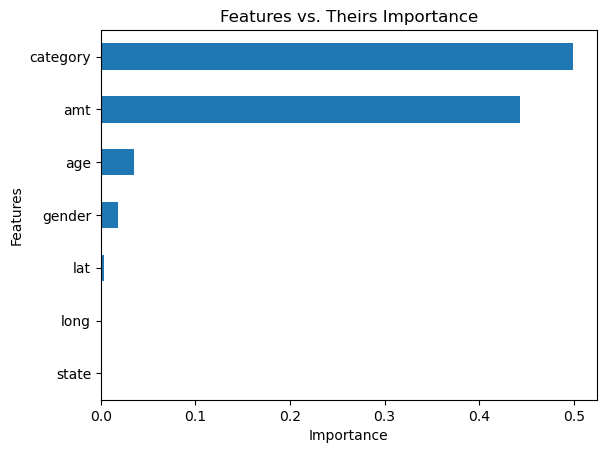

In [20]:
feat_imp.plot.barh()
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Features vs. Theirs Importance");

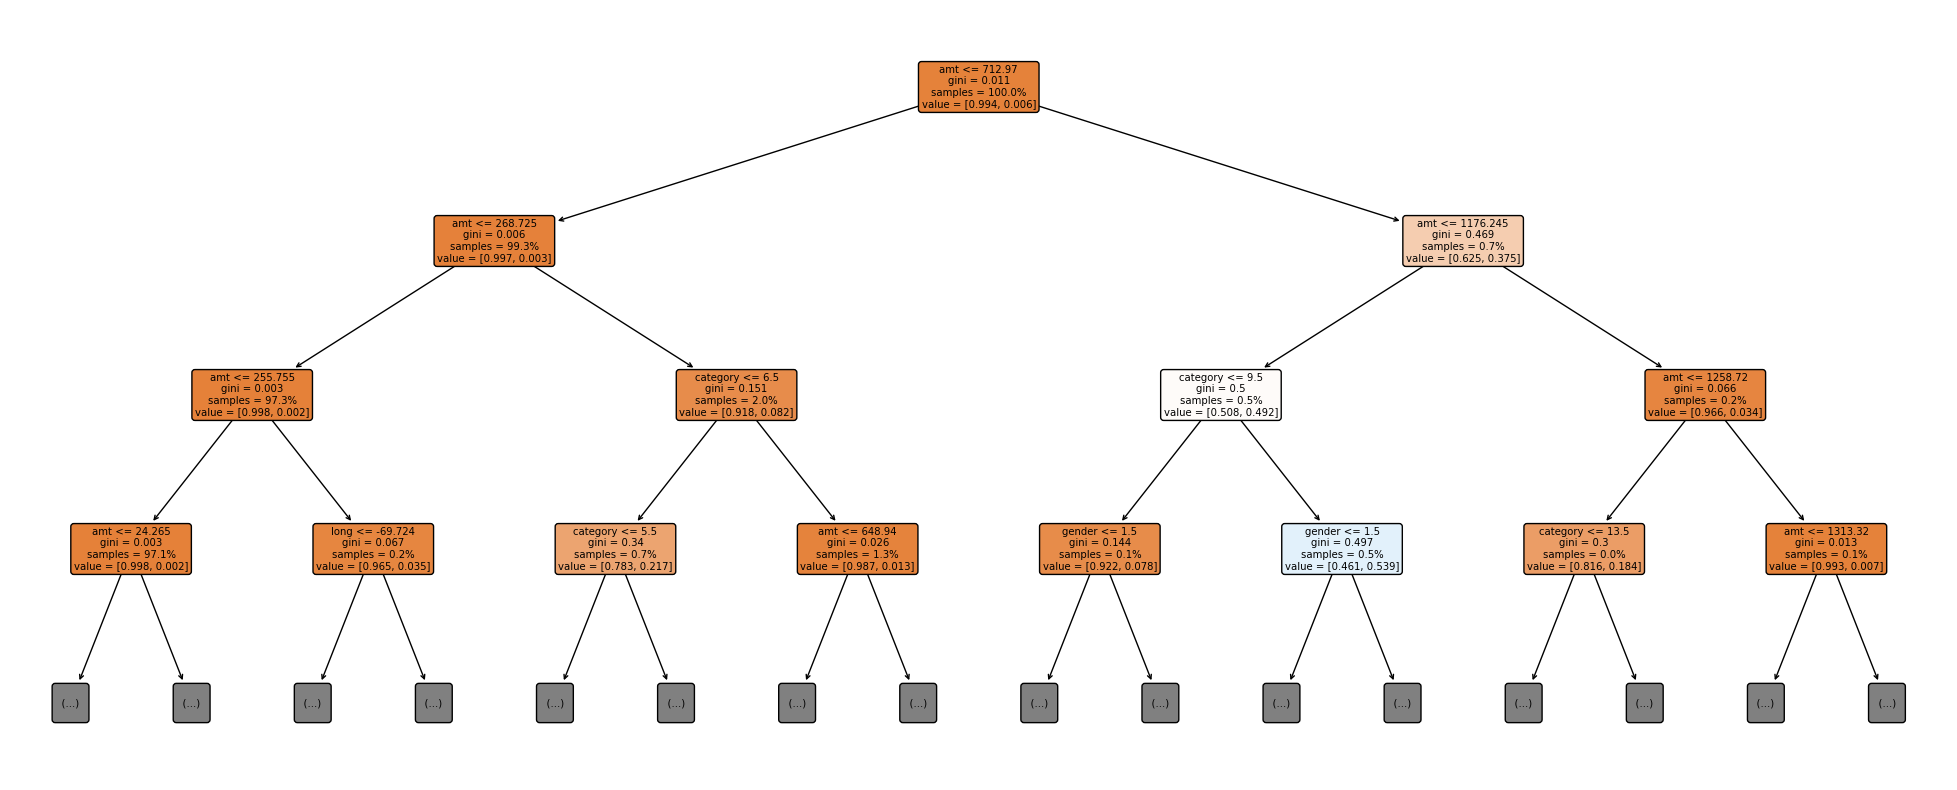

In [21]:
fig, ax = plt.subplots(figsize= (25, 10))
plot_tree(
    clf_final.named_steps["decisiontreeclassifier"],
    max_depth= 3,
    feature_names= features,
    proportion= True,
    ax= ax,
    rounded= True,
    filled= True)
plt.show()

In [23]:
clf_final.get_feature_names_out

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['category', 'gender', 'state'],
                                mapping=[{'col': 'category',
                                          'data_type': dtype('O'),
                                          'mapping': travel             1
entertainment      2
health_fitness     3
grocery_net        4
kids_pets          5
grocery_pos        6
misc_pos           7
gas_transport      8
food_dining        9
misc_net          10
home              11
personal_care     12
shopping_pos      13
shopping_net      14
NaN               -2
dtype: int64},
                                         {'col': 'gender',
                                          'data_ty...
dtype: int64},
                                         {'col': 'state',
                                          'data_type': dtype('O'),
                                          'mapping': LA      1
WA      2
TX      3
